## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


## 1. prepare data

In [63]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

'''
for .png format image files
matplotlib.imread() will read in to scale 0 to 1.0
cv2.imread() will scale them from 0 to 255. 
'''
doprint = True
%matplotlib inline

#### utility functions for the project

In [64]:
def draw_boxes(img, bboxes, color = (0, 0, 225), thick = 6):
    drawimg = np.copy(img)
    for bbox in bboxes:
        p1, p2 = bbox
        cv2.rectangle(drawimg, p1, p2, color, thick)
    return drawimg

unit test for functiton draw_boxes()

In [65]:
def test_draw_boxes():
    filename = './test_images/test5.jpg'
    img = cv2.imread(filename)
    if doprint:
        print('draw boxes on image ', filename, ' with size ', img.shape)
    bboxes = []
    p1, p2 = (40, 40), (126, 217)
    bboxes.append((p1, p2))
    p1, p2 = (0, 0), (1280, 720)
    bboxes.append((p1, p2))
    p1, p2 = (50, 50), (20, 20)
    bboxes.append((p1, p2))
    
    result = draw_boxes(img, bboxes, color = (0, 0, 225), thick = 6)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

draw boxes on image  ./test_images/test5.jpg  with size  (720, 1280, 3)


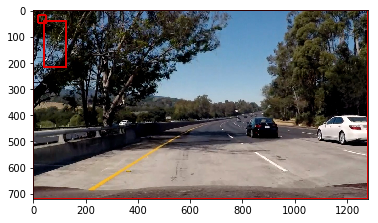

In [66]:
test_draw_boxes()

#### function for template matching

In [67]:
def find_matches(img, template_list):
    # Define an empty list to take bbox coords
    bbox_list = []
    # Other options include: cv2.TM_CCORR_NORMED', 'cv2.TM_CCOEFF', 'cv2.TM_CCORR',
    #         'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED'
    method = cv2.TM_CCOEFF_NORMED
    # Iterate through template list
    for temp in template_list:
        tmp = mpimg.imread(temp)
        # Use cv2.matchTemplate() to search the image
        result = cv2.matchTemplate(img, tmp, method)
        # Use cv2.minMaxLoc() to extract the location of the best match
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        # Determine a bounding box for the match
        w, h = (tmp.shape[1], tmp.shape[0])
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        bbox_list.append((top_left, bottom_right))
    return bbox_list

In [68]:
import glob
import os
def test_find_matches():
    template_list = glob.glob('./examples/car_templates/*.jpeg')
    filename = './test_images/test5.jpg'
    if doprint:
        print('finding the matched bbox of pattern in image file', filename)
        print('template files: ', template_list)
    
    fig = plt.figure()
    n = len(template_list)
    for i, template in enumerate(template_list):
        tempimg = plt.imread(template)
        plt.subplot(101 + 20 *n +  i*2)
        plt.imshow(tempimg)
        plt.title(os.path.split(template)[-1])
    fig = plt.figure()
    img = plt.imread(filename)
    bbox_list = find_matches(img, template_list)
    result = draw_boxes(img, bbox_list)
    plt.imshow(result)
    plt.title('the matched bboxes on the image '+ filename)


finding the matched bbox of pattern in image file ./test_images/test5.jpg
template files:  ['./examples/car_templates\\3.jpeg', './examples/car_templates\\4.jpeg', './examples/car_templates\\5.jpeg']


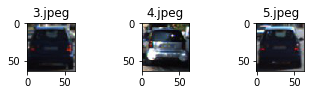

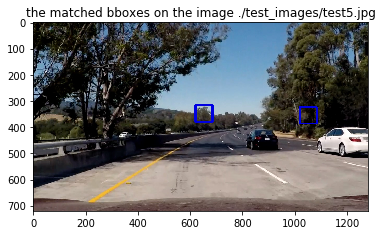

In [69]:
test_find_matches()

we can see that template_maches function doesnt't work well

In [70]:
from skimage.feature import hog
def get_hog_feature(img, orient = 9, pix_per_cell = 8, cell_per_block = 2, vis = False, feature_vec = True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                              pixels_per_cell=(pix_per_cell, pix_per_cell), 
                              cells_per_block=(cell_per_block, cell_per_block), 
                              visualise=vis, feature_vector = feature_vec,
                              block_norm="L2-Hys")
        return features, hog_image
    else:
        features = hog(img, 
                       orientations = orient,
                       pixels_per_cell = (pix_per_cell, pix_per_cell), 
                       cells_per_block = (cell_per_block, cell_per_block), 
                       visualise = vis, feature_vector = feature_vec,
                       block_norm = "L2-Hys")
        return features

In [71]:
import glob
def test_get_hog_feature(vis = False):
    filename = glob.glob('./examples/car_templates/*.jpeg')[0]
    img = plt.imread(filename)
    channel = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if vis:
        print('running hog with visualize = True')
        features, hog_image = get_hog_feature(channel, vis = vis)
        fig = plt.figure()
        plt.subplot(131)
        plt.imshow(img)
        plt.title('raw img')
        plt.subplot(132)
        plt.imshow(channel, cmap='gray')
        plt.title('gray channel')
        plt.subplot(133)
        plt.imshow(hog_image)
        plt.title('hog img')  
        if doprint:
            print('feature data size is', features.shape)
    else:
        if doprint:
            print('running hog with visualize = False')
        features = get_hog_feature(channel, vis = vis)
        print(type(features), features.shape)
                

running hog with visualize = True
feature data size is (1764,)
running hog with visualize = False
<class 'numpy.ndarray'> (1764,)


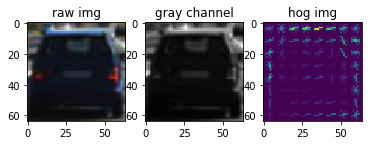

In [72]:
test_get_hog_feature(vis = True)
test_get_hog_feature(vis = False)

In [73]:
def get_color_histogram(img, nbins = 32, bins_range = (0, 256)):
    # get all the 3 channel image
    r_hist = np.histogram(img[:,:,0], bins = nbins, range = bins_range)
    g_hist = np.histogram(img[:,:,1], bins = nbins, range = bins_range)
    b_hist = np.histogram(img[:,:,2], bins = nbins, range = bins_range)
    bin_center = (r_hist[1][0:-1] + r_hist[1][1:])/2
    hist = np.concatenate((r_hist[0], g_hist[0], b_hist[0]))
    return r_hist, g_hist, b_hist, bin_center, hist


In [74]:
def test_get_color_histogram():
    filename = glob.glob('./examples/car_templates/*.jpeg')[0]
    img = plt.imread(filename)
    rhist, ghist, bhist, bin_centers, hist = get_color_histogram(img, nbins = 32, bins_range = (0, 256))
    
    # explore the return rhis
    if doprint:
        print('histogram data has size', len(rhist[0]))
        print('histogram boundry has size', len(rhist[1]))
        print('histogram center has size', len(bin_centers))
        print('total histogram data has size', len(hist))
        print('bin center are: ', bin_centers)
        print('bin corner are: ', rhist[1])
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bin_centers, rhist[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bin_centers, ghist[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bin_centers, bhist[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')

histogram data has size 32
histogram boundry has size 33
histogram center has size 32
total histogram data has size 96
bin center are:  [   4.   12.   20.   28.   36.   44.   52.   60.   68.   76.   84.   92.
  100.  108.  116.  124.  132.  140.  148.  156.  164.  172.  180.  188.
  196.  204.  212.  220.  228.  236.  244.  252.]
bin corner are:  [   0.    8.   16.   24.   32.   40.   48.   56.   64.   72.   80.   88.
   96.  104.  112.  120.  128.  136.  144.  152.  160.  168.  176.  184.
  192.  200.  208.  216.  224.  232.  240.  248.  256.]


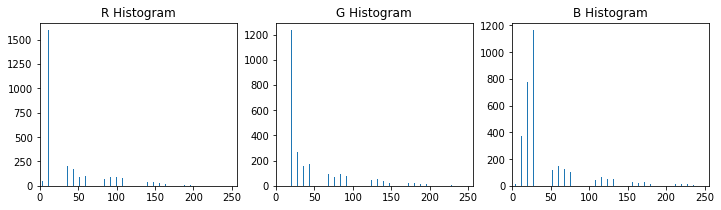

In [75]:
test_get_color_histogram()

In [76]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = 0
    data_dict['n_cars'] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = 0
    data_dict['n_notcars'] = len(notcar_list)
    
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = (0, 0, 0)
    if len(car_list):
        file = car_list[0]
    elif len(notcarlist):
        file = notcar_list[0]
    else:
        assert 0, 'no image'
        
    img = cv2.imread(file)
    data_dict['image_shape']= img.shape
    
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = img.dtype
    
    # Return data_dict
    return data_dict

In [77]:
from mpl_toolkits.mplot3d import Axes3D

def test_data_look(imgfile):
    def plot3d(pixels, colors_rgb,
               axis_labels = list("RGB"), 
               axis_limits = ((0, 255), (0, 255), (0, 255))):
        """Plot pixels in 3D."""

        # Create figure and 3D axes
        fig = plt.figure(figsize=(8, 8))
        ax = Axes3D(fig)

        # Set axis limits
        ax.set_xlim(*axis_limits[0])
        ax.set_ylim(*axis_limits[1])
        ax.set_zlim(*axis_limits[2])

        # Set axis labels and sizes
        ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
        ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
        ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
        ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

        # Plot pixel values with colors given in colors_rgb
        ax.scatter(
            pixels[:, :, 0].ravel(),
            pixels[:, :, 1].ravel(),
            pixels[:, :, 2].ravel(),
            c=colors_rgb.reshape((-1, 3)), edgecolors='none')

        return ax

    img = cv2.imread(imgfile)
    
    # Select a small fraction of pixels to plot by subsampling it
    scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
    img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

    # Convert subsampled image to desired color space(s)
    img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
    img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
    img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV)
    img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting
    img_small_hsv = img_small_HSV / 255.
    img_small_luv = img_small_LUV / 255.

    # Plot and show
    plot3d(img_small_RGB, img_small_rgb)
    plot3d(img_small_HSV, img_small_hsv, axis_labels = list("HSV"), axis_limits = ((0, 255), (0, 255), (0, 255)))
    plot3d(img_small_LUV, img_small_luv, axis_labels = list("LUV"), axis_limits = ((0, 255), (0, 255), (0, 255)))
        
    plt.show()

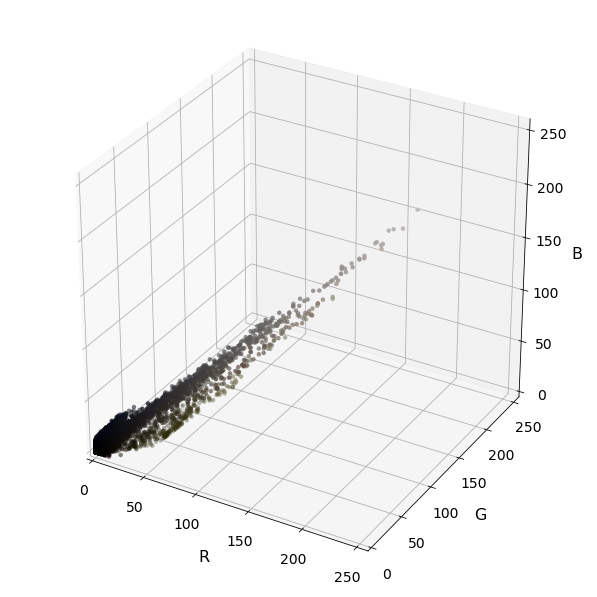

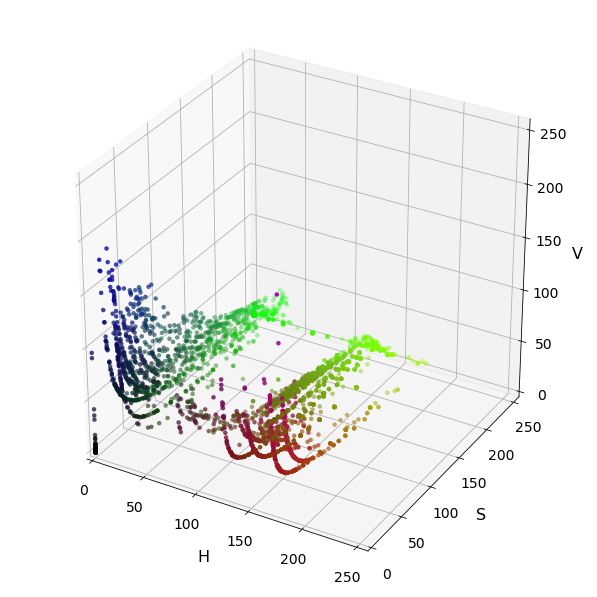

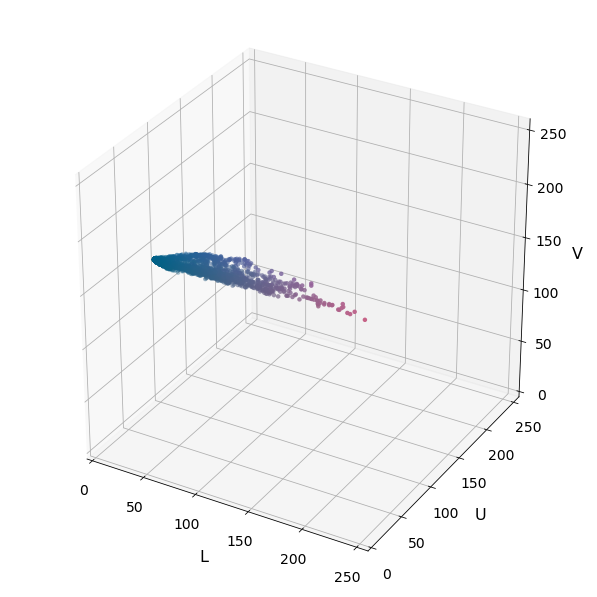

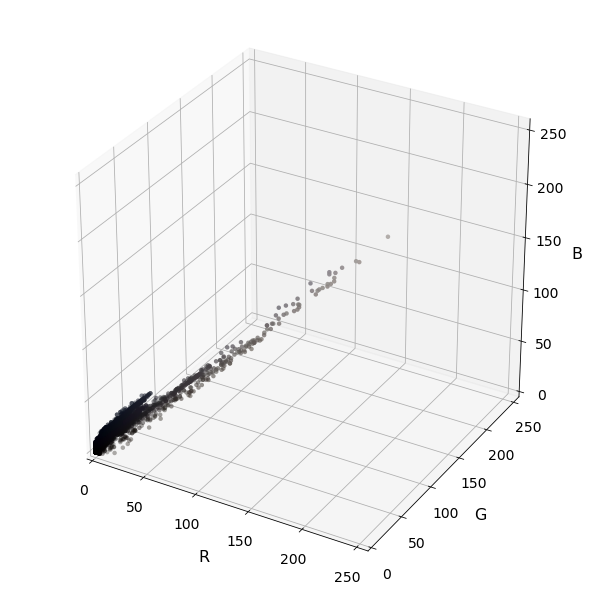

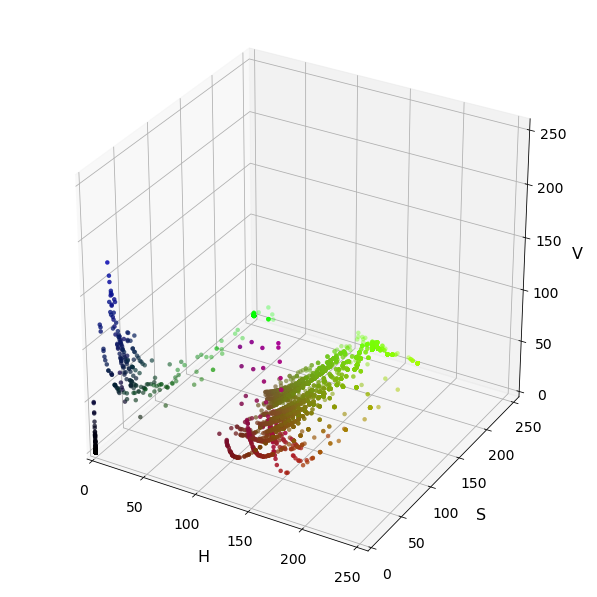

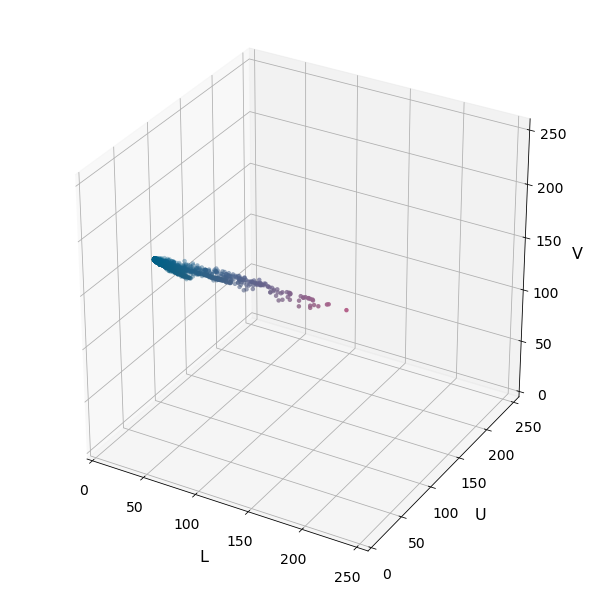

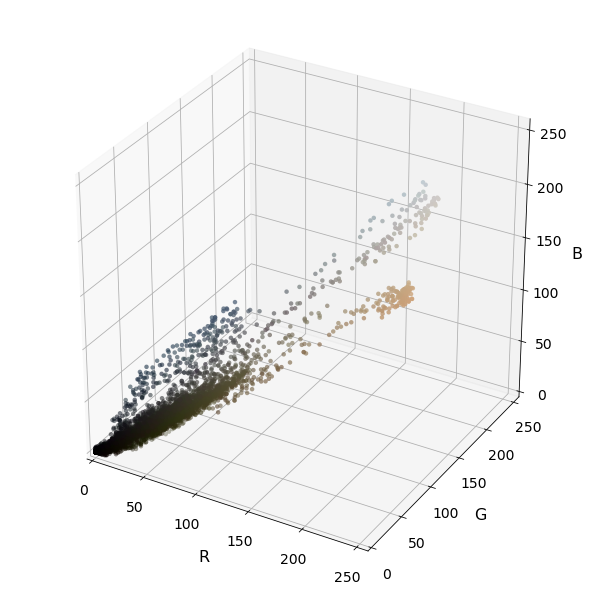

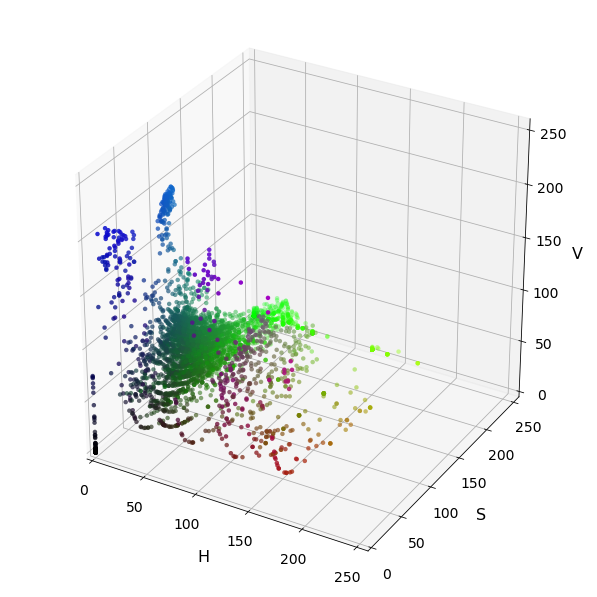

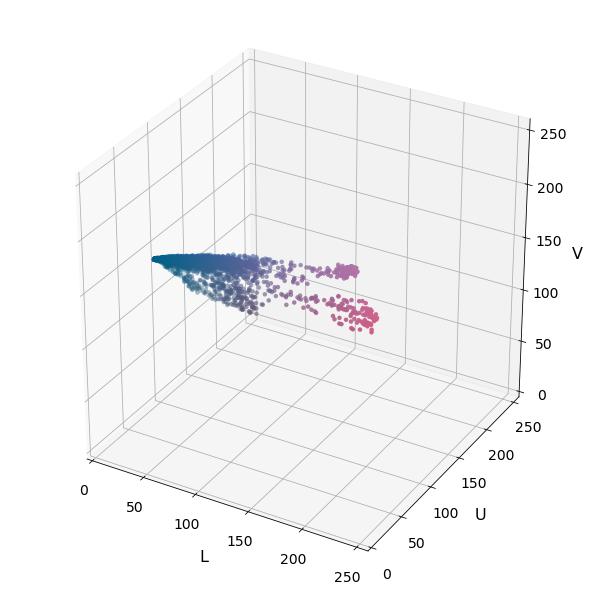

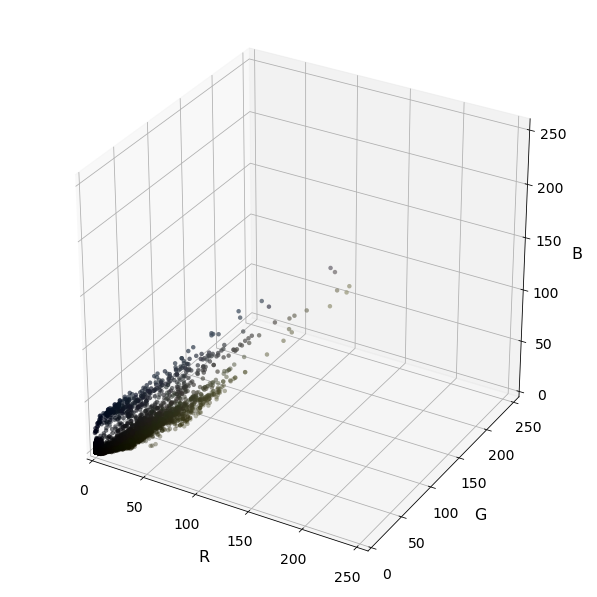

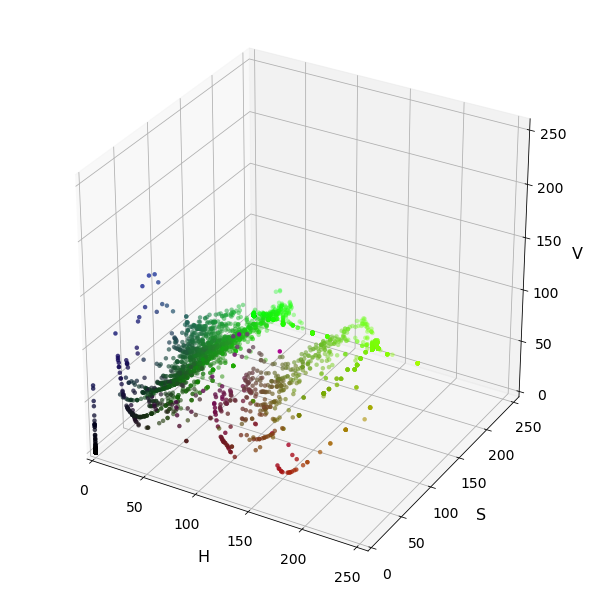

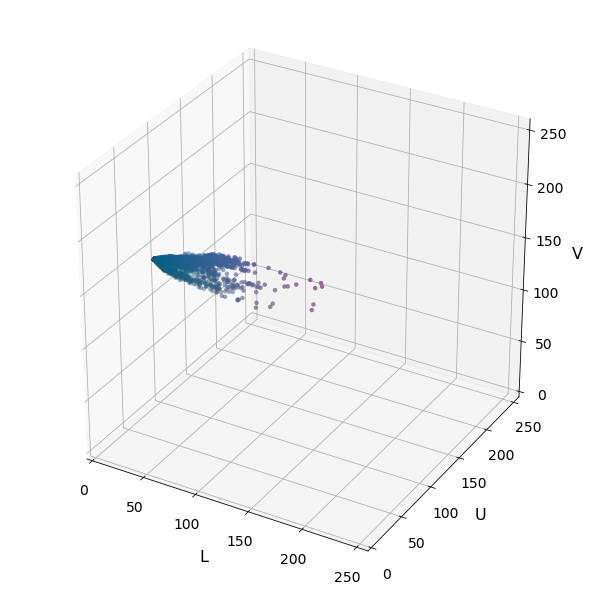

In [78]:
import glob
imgfiles = glob.glob('./examples/notcar_templates/*.jpeg')
for imgfile in imgfiles:
    test_data_look(imgfile)


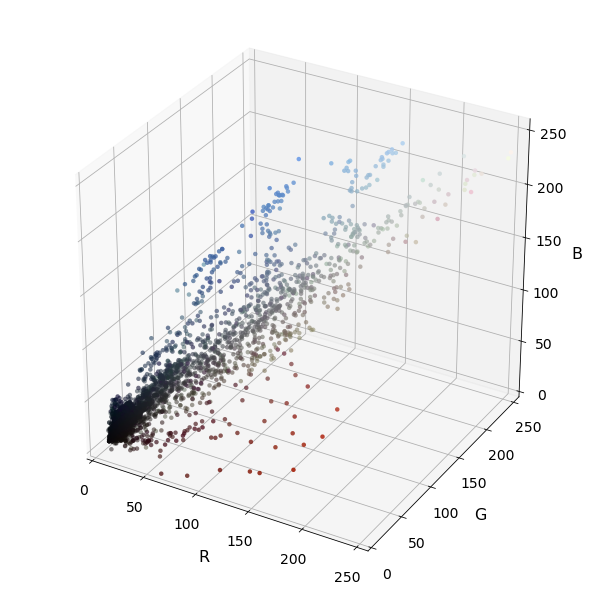

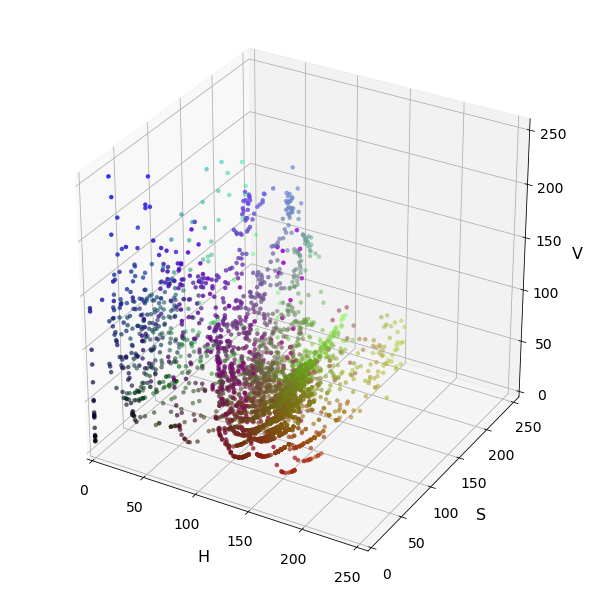

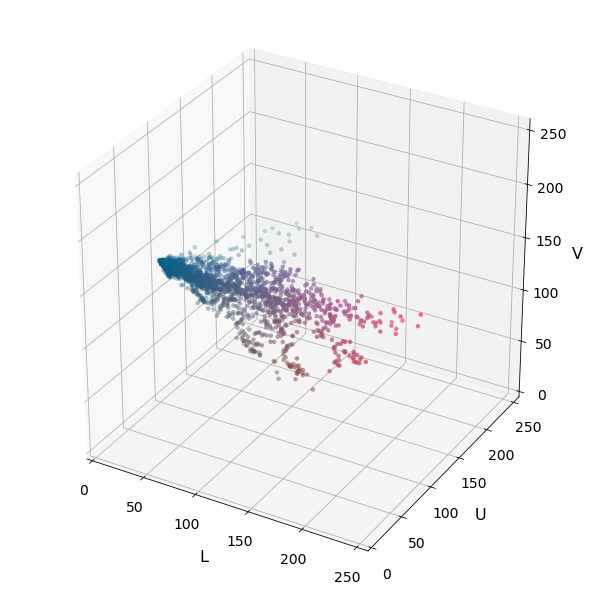

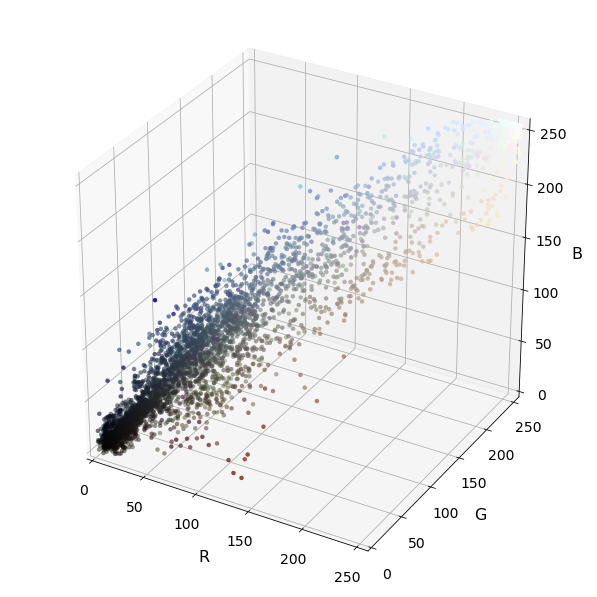

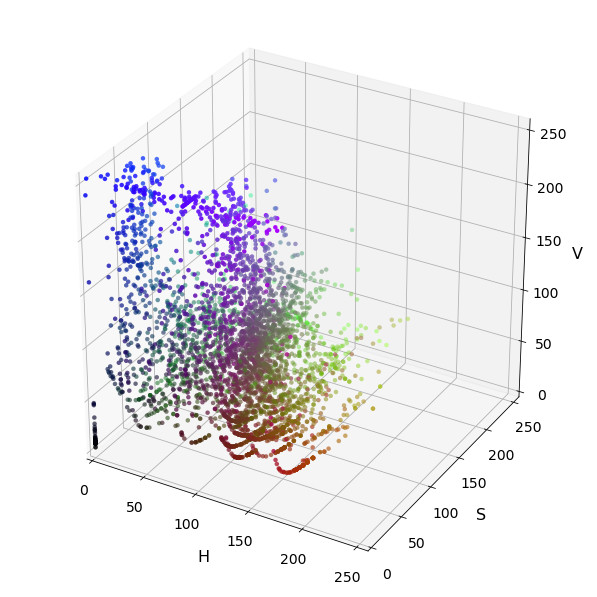

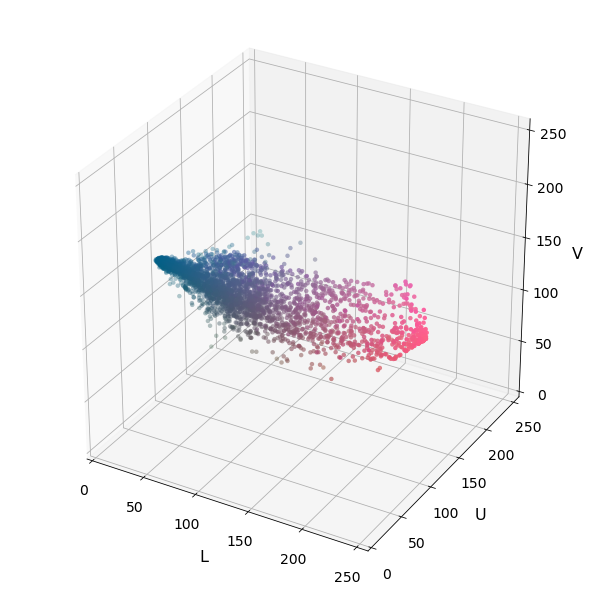

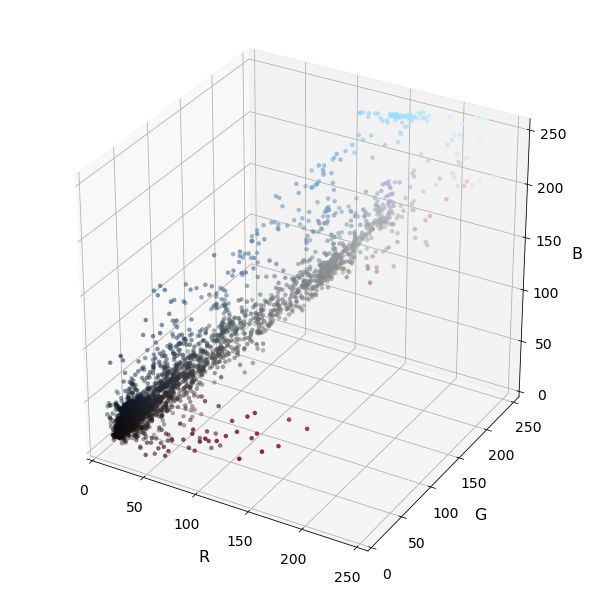

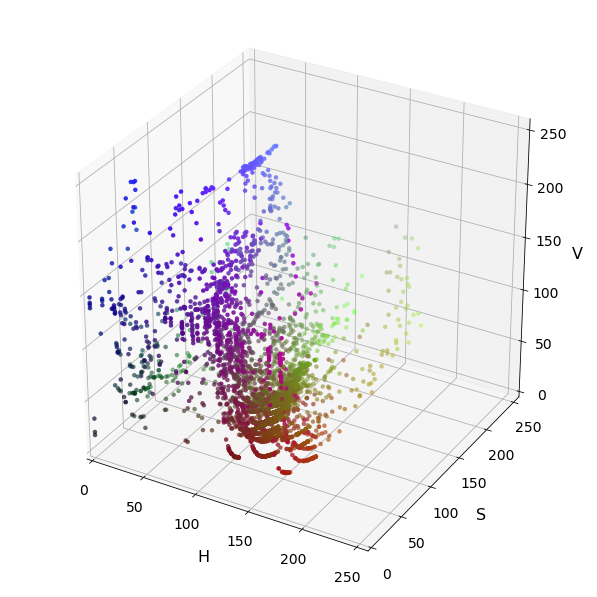

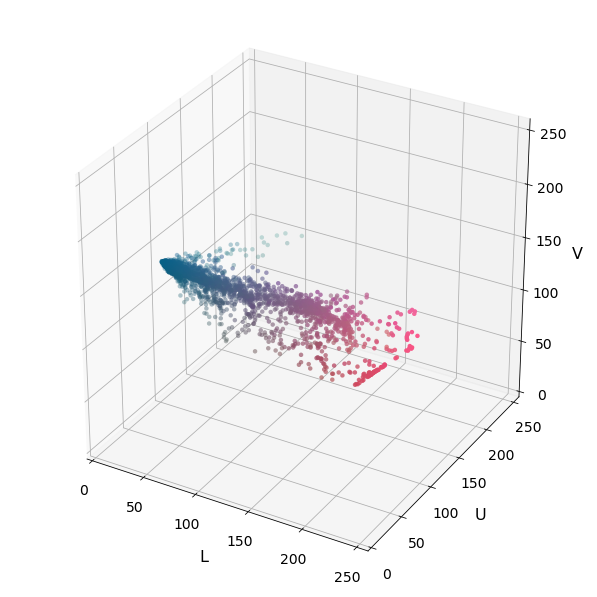

In [79]:
imgfiles = glob.glob('./examples/car_templates/*.jpeg')
for imgfile in imgfiles:
    test_data_look(imgfile)

In [80]:
def get_spatial_feature(img, size = (32,32), imgshow = False):
    img2 = cv2.resize(img, size)
    feature = img2.ravel()
    if imgshow:
        plt.imshow(img2)
        plt.title('resized image, size = ' + str(img2.shape))
    return feature

In [81]:
def test_get_spatial_feature():
    filename = './test_images/test1.jpg'
    img = plt.imread(filename)
    result = get_spatial_feature(img, imgshow = True)
    fig = plt.figure()
    plt.imshow(img)
    plt.title('the raw image, size is' + str(img.shape))

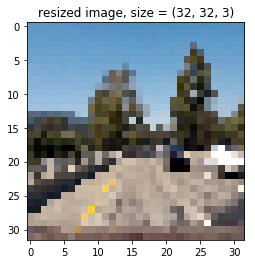

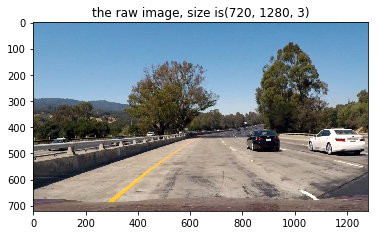

In [82]:
test_get_spatial_feature()

## combine above functions all
add them to extract features for classification

In [112]:
def get_cspace_img(img, cspace = 'RGB'):
    if cspace == 'RGB':
        return np.copy(img)
    if cspace == 'BGR':
        return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    if cspace == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if cspace == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if cspace == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if cspace == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    assert 0, 'not valid color space:' + cspace
    
# use the method above to extract features and do the preprocessing
def extract_features(imgfiles, 
                     spatial_flag = True, spatial_cspace = 'YCrCb', spatial_size = (32, 32),
                     hist_flag = True, hist_cspace = 'YCrCb', hist_bins = 32, hist_range=(0, 256),
                     hog_flag = True, hog_cspace = 'YCrCb', hog_channel = 'ALL', hog_vis = False, hog_feature_vec = True):
    features = []
    for file in imgfiles:
        image = mpimg.imread(file)
        if 'png' in file:
            image = image*255
        
        spatial_features = None
        hist_features = None
        hog_features = None
        
        # 1. convert colors based on required color space, if other than 'RGB'
        if spatial_flag:
            feature_image = get_cspace_img(image, spatial_cspace)
            spatial_features = get_spatial_feature(feature_image, size = spatial_size)
        
        #3.  Apply color_hist() also with a color space option now
        if hist_flag:
            feature_image = get_cspace_img(image, hist_cspace)
            rhist, ghist, bhist, bin_centers, hist_features = get_color_histogram(
                feature_image,
                nbins = hist_bins, 
                bins_range = hist_range)
        
        #4. Apply get hog_feature()
        if hog_flag:
            feature_image = get_cspace_img(image, hog_cspace)
            if hog_channel in [0, 1, 2]:
                hog_features = get_hog_feature(feature_image[:,:,hog_channel], 
                                               orient = 9, 
                                               pix_per_cell = 8, 
                                               cell_per_block = 2, 
                                               vis = hog_vis,
                                               feature_vec = hog_feature_vec)
            elif hog_channel == 'ALL':
                hog_features = []
                for i in range(3):
                    hog_feature = get_hog_feature(feature_image[:, :, i],
                                                 orient = 9,
                                                 pix_per_cell = 8,
                                                 cell_per_block = 2,
                                                 vis = hog_vis,
                                                 feature_vec = hog_feature_vec)
                    hog_features.append(hog_feature)
                hog_features = np.hstack(hog_features)
        #4. Append the new feature vector to the features list
        if doprint and file == imgfiles[0]:
            if spatial_flag:
                print('spatial_features:')
                print('datatype = ', type(spatial_features))
                print('data shape = ', spatial_features.shape)
            if hist_flag:
                print('\nhist_features')
                print('data len =', len(hist_features))
            if hog_flag:
                print('\n hog features')
                print('data type = ', type(hog_features))
                print('data shape = ', hog_features.shape)
                print('\n')
        features_list = []
        if spatial_flag:
            features_list.append(spatial_features)
        if hist_flag:
            features_list.append(hist_features)
        if hog_flag:
            features_list.append(hog_features)
        features.append(np.concatenate(features_list))

    return features

In [113]:
doprint = False
def test_extract_features():
    imgfiles = glob.glob('./test_images/test1.jpg')
    imgfiles = glob.glob('./examples/car_templates/*.jpeg')
    print('img files to extract features:')
    print('\n'.join(imgfiles))
    features1 = extract_features(imgfiles, hog_channel = 'ALL')
    features2 = extract_features(imgfiles, spatial_cspace = 'HLS')
    features3 = extract_features(imgfiles, hist_cspace = 'YUV')
    print('features1 size =', features1[0].shape)
    print('features2 size =', features2[0].shape)
    print('features3 size =', features2[0].shape)
    

In [114]:
test_extract_features()

img files to extract features:
./examples/car_templates\3.jpeg
./examples/car_templates\4.jpeg
./examples/car_templates\5.jpeg
features1 size = (8460,)
features2 size = (8460,)
features3 size = (8460,)


In [115]:
from sklearn.preprocessing import StandardScaler

def normalize_features(feature_list, scaler = None):
    X = np.vstack(feature_list).astype(np.float64)
    if scaler == None:
        scaler = StandardScaler().fit(X)
        scaled_X = scaler.transform(X)
        return scaled_X, scaler
    else:
        return scaler.transform(X)

In [116]:
def test_normalize_features():
    X = [[1,2,3], [4,5,6], [2,2,2]]
    X1, scaler = normalize_features(X)
    X2 = normalize_features(X, scaler)
    print('the raw X is \n', X,'\n')
    print('the scaled X1 is\n', X1,'\n')
    print('the scaled X2 is\n', X2)

In [117]:
test_normalize_features()

the raw X is 
 [[1, 2, 3], [4, 5, 6], [2, 2, 2]] 

the scaled X1 is
 [[-1.06904497 -0.70710678 -0.39223227]
 [ 1.33630621  1.41421356  1.37281295]
 [-0.26726124 -0.70710678 -0.98058068]] 

the scaled X2 is
 [[-1.06904497 -0.70710678 -0.39223227]
 [ 1.33630621  1.41421356  1.37281295]
 [-0.26726124 -0.70710678 -0.98058068]]


In [118]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

def tunning_classifier(data, target, parameters):
    svr = svm.SVC()
    # clf = grid_search.GridSearchCV(svr, parameters)
    clf = GridSearchCV(svr, parameters)
    clf.fit(data, target)
    return clf, clf.best_params_


In [119]:
import random
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

def test_tunning_classifier():
    def build_dataset1():
        iris = datasets.load_iris()
        return iris.data, iris.target
    
    def build_dataset2():
        n = 1000
        features_1 = np.zeros([n, 2]) + np.random.random(size = [n, 2])
        features_0 = np.ones([n,2]) + np.random.random(size = [n, 2])
        features = np.vstack((features_1, features_0))
        
        labels_0 = np.zeros([n,1])
        labels_1 = np.ones([n,1])
        labels = np.vstack((labels_0, labels_1))
        labels = labels.reshape([2*n])
        
        return features, labels

    data,target = build_dataset2()
    print('dataset shape is:', data.shape, target.shape)
    parameters = {'kernel':('linear', 'rbf'), 'C':[1,2,3,4,5,6,7,8,9, 10]}
    clf, result = tunning_classifier(data, target, parameters)
    print('fine tune result is', result)
    
    data, target = build_dataset1()
    print('dataset shape is:', data.shape, target.shape)
    parameters = {'kernel':('linear', 'rbf'), 'C':[1,2,3,4,5,6,7,8,9, 10]}
    clf, result = tunning_classifier(data, target, parameters)
    print('fine tune result is', result)

In [120]:
test_tunning_classifier()

dataset shape is: (2000, 2) (2000,)
fine tune result is {'C': 1, 'kernel': 'linear'}
dataset shape is: (150, 4) (150,)
fine tune result is {'C': 2, 'kernel': 'linear'}


#### get data set


In [121]:
doprint = False
notcar_imgfiles = glob.glob('./dataset/non-vehicles_smallset/notcars*/*.jpeg')
notcar_imgfiles = glob.glob('./dataset/non-vehicles/*/*.png')
notcar_features = np.array(extract_features(notcar_imgfiles))

print('not car dataset shape = ', notcar_features.shape)

not car dataset shape =  (8968, 8460)


In [122]:
car_imgfiles = glob.glob('./dataset/vehicles_smallset/cars*/*.jpeg')
car_imgfiles = glob.glob('./dataset/vehicles/*/*.png')
car_features = np.array(extract_features(car_imgfiles))

print('car dataset shape = ', car_features.shape)

car dataset shape =  (8792, 8460)


#### get the total features and labels

In [123]:
total_features = np.vstack((notcar_features, car_features)).astype(np.float64)
total_labels = np.hstack((np.zeros(len(notcar_features)), np.ones(len(car_features))))
print('total features has shape = ', total_features.shape,'total labels shape =', total_labels.shape)

total_features_norm, normalizer = normalize_features(total_features)

from sklearn.utils import shuffle
total_features, total_labels = shuffle(total_features, total_labels)

total features has shape =  (17760, 8460) total labels shape = (17760,)


split dataset into training and testing

In [124]:
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
def split_dataset(features, labels, test_size = 0.2):
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = test_size, random_state=rand_state)
    return X_train, X_test, y_train, y_test

In [125]:
X_train, X_test, y_train, y_test = split_dataset(total_features, total_labels, test_size = 0.2)
print('check splited data size')
print('datasize for train:', X_train.shape, y_train.shape)
print('datasize for test:', X_test.shape, y_test.shape)
print('split ratio is:', np.float(X_test.shape[0]/ (X_test.shape[0] + X_train.shape[0])))
print('\ncheck split label balance:')
print('for train, ', np.sum(y_train), ' of ', y_train.shape[0], ' samples are positive')
print('for test, ', np.sum(y_test), ' of ', y_test.shape[0], ' samples are positive')

check splited data size
datasize for train: (14208, 8460) (14208,)
datasize for test: (3552, 8460) (3552,)
split ratio is: 0.2

check split label balance:
for train,  7057.0  of  14208  samples are positive
for test,  1735.0  of  3552  samples are positive


In [ ]:
parameters = {'kernel':('linear', 'rbf'), 
              'C':[0.02, 0.04, 0.1, 0.5, 1.0, 1.5, 2.0, 4.0]}
svm1, result = tunning_classifier(X_test, y_test, parameters)
print(result)

seem linear kernel with C = 0.02 is the best

more fine tune for C near range 0.02

In [102]:
parameters = {'kernel':('linear',), 
              'C':[0.01, 0.015, 0.02, 0.024, 0.03, 0.035, 0.04]}
svm2, result = tunning_classifier(X_test, y_test, parameters)
print(result)

{'C': 0.01, 'kernel': 'linear'}


training it and check the result

then we decide to use linear kernel and C

In [78]:
from sklearn.svm import LinearSVC
svc1 = LinearSVC()
svc1.fit(X_train, y_train)
accuracy = svc1.score(np.array(X_test), np.array(y_test))
print('Test Accuracy of SVC = ', accuracy)

Test Accuracy of SVC =  0.991397849462


In [37]:
print('My SVC predicts: ', svc1.predict(X_test[20:30]))
print('For labels     : ', y_test[20:30])

My SVC predicts:  [ 0.  0.  1.  0.  0.  1.  1.  0.  1.  1.]
For labels     :  [ 0.  0.  1.  0.  0.  1.  1.  0.  1.  1.]


## 2. car search

In [54]:
def slide_window(img, 
                 x_start_stop = (None, None),
                 y_start_stop = (350, 700), 
                 xy_window = (64, 64),
                 xy_overlap = (0.75, 0.75)):
    # If x and/or y start/stop positions not defined, set to image size
    window_list = []
    x_start, x_stop = x_start_stop
    y_start, y_stop = y_start_stop
    
    if x_start == None: 
        x_start = 0
    if x_stop == None: 
        x_stop = img.shape[1]
    if y_start == None:
        y_start = 0
    if y_stop == None:
        y_stop = img.shape[0]
    for x in range(x_start, x_stop, int(xy_window[0] * xy_overlap[0])):
        for y in range(y_start, y_stop, int(xy_window[1] * xy_overlap[1])):
            p1 = (x, y)
            p2 = (x + xy_window[0], y + xy_window[1])
            window_list.append((p1, p2))
    return window_list

In [55]:
def test_slide_window():
    img = plt.imread('./test_images/test1.jpg')
    window_list = slide_window(img)
    result = draw_boxes(img, window_list)
    print('totally ', len(window_list), ' windows plotted on the img')
    plt.imshow(result)

totally  216  windows plotted on the img


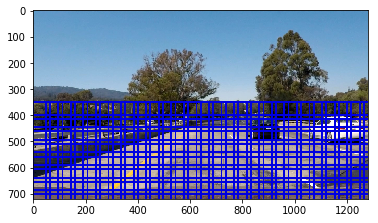

In [56]:
test_slide_window()

In [57]:
def search_windows(img, windows, clf, scaler, color_space='YCrCb', 
                   spatial_size = (32, 32), 
                   hist_bins = 32, 
                   hist_range = (0, 256), orient = 9, 
                   pix_per_cell = 8, cell_per_block = 2, 
                   hog_channel = 'ALL', spatial_feat = True, 
                   hist_feat = True, hog_feat = True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        features = single_img_features(test_img, 
                                       color_space = color_space, 
                                       spatial_size = spatial_size, hist_bins = hist_bins, 
                                       orient = orient, pix_per_cell = pix_per_cell, 
                                       cell_per_block = cell_per_block, 
                                       hog_channel = hog_channel, spatial_feat = spatial_feat, 
                                       hist_feat = hist_feat, hog_feat = hog_feat)
        # test_features = scaler.transform(np.array(features).reshape(1, -1))
        if window == windows[0]:
            print('check single_img_features')
            print(features.shape)
        test_features = scaler.transform(features.reshape(1, -1))
        if window == windows[0]:
            print('transformed', test_features.shape)
        prediction = clf.predict(test_features)
        if prediction == 1:
            on_windows.append(window)
    return on_windows    

In [58]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space = 'YCrCb', spatial_size = (32, 32),
                        hist_bins = 32, orient = 9, 
                        pix_per_cell = 8, cell_per_block = 2, hog_channel = 'ALL',
                        spatial_feat = True, hist_feat = True, hog_feat = True):    
    img_features = []
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)      

    if spatial_feat == True:
        spatial_features = get_spatial_feature(feature_image, size = spatial_size)
        # spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)

    if hist_feat == True:
        # hist_features = color_hist(feature_image, nbins=hist_bins)
        rhist, ghist, bhist, bin_centers, hist_features = get_color_histogram(
            feature_image,
            nbins = hist_bins)
        img_features.append(hist_features)
            
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_feature = get_hog_feature(feature_image[:,:,channel], 
                                               orient, pix_per_cell, cell_per_block, 
                                               vis=False, feature_vec=True)                
                hog_features.extend(get_hog_feature)      
        else:
            hog_features = get_hog_feature(feature_image[:,:,hog_channel], orient, 
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        img_features.append(hog_features)

    return np.concatenate(img_features)

In [61]:
def test_search_window():
    imgfile = './test_images/test1.jpg'
    img = plt.imread(imgfile)
    windows_list = slide_window(img)
    on_windows = search_windows(img, windows_list, svc1, normalizer, color_space = 'RGB', 
                   spatial_size = (32, 32), 
                   hist_bins = 32, 
                   hist_range = (0, 256), orient = 9, 
                   pix_per_cell = 8, cell_per_block = 2, 
                   hog_channel = 0, spatial_feat = True, 
                   hist_feat = True, hog_feat = True)
    print('on_windows size is', len(on_windows))
    result = draw_boxes(img, on_windows)
    plt.imshow(result)

In [62]:
test_search_window()

NameError: name 'svc1' is not defined

In [56]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, clf, X_scaler, 
              orient, cspace, hog_channel, pix_per_cell, cell_per_block, spatial_size, hist_bins):

    bbox_list = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255.
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    ctrans_tosearch = get_cspace_img(img_tosearch, cspace)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above, step one cell foreach block
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step, this is the cell step for windows movement
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_feature(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_feature(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_feature(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            
            if hog_channel == 0:
                hog_features = hog_feat1
            elif hog_channel == 1:
                hog_features = hog_feat2
            elif hog_channel == 2:
                hog_features = hog_feat3
            elif hog_channel == 'ALL':
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            # spatial_features = bin_spatial(subimg, size=spatial_size)
            spatial_features = get_spatial_feature(subimg, size = spatial_size)
            bin1, bin2, bin3, bin_centers, hist_features = get_color_histogram(subimg, nbins = hist_bins)

            # Scale features and make a prediction
            if xb == 0 and yb == 0 and doprint:
                print(spatial_features.shape)
                print(hist_features.shape)
                print(hog_features.shape)
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                p1 = (xbox_left, ytop_draw + ystart)
                p2 = (xbox_left + win_draw, ytop_draw + win_draw + ystart)
                bbox_list.append((p1, p2))
    return draw_img, bbox_list
    

In [57]:
def test_find_cars():
    img = plt.imread('./test_images/test1.jpg')
    ystart, ystop = 0, img.shape[0]
    scale = 1.0
    X_scaler = normalizer
    orient = 9
    pix_per_cell, cell_per_block = 8, 2
    orient = 9
    spatial_size = (32, 32)
    hist_bins = 32
    
    result, bbox_list = find_cars(img, 
                                  ystart = ystart, ystop = ystop, 
                                  scale = scale, clf = clf_svc, X_scaler = X_scaler,
                                  cspace = 'RGB', hog_channel = 0,
                                  orient = orient, pix_per_cell = pix_per_cell, cell_per_block = cell_per_block,
                                  spatial_size = spatial_size, 
                                  hist_bins = hist_bins)
    plt.imshow(result)
    print(len(bbox_list))

19


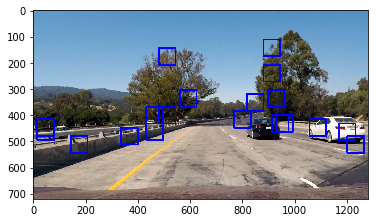

In [58]:
test_find_cars()

In [71]:
from scipy.ndimage.measurements import label
def create_heat_map(img, bbox_list, threshold):
    def apply_threshold(heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        return heatmap
    
    def add_heat(heatmap, bbox_list):
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        return heatmap

    def draw_labeled_bboxes(img, labels):
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        return img
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bbox_list)
    heat = apply_threshold(heat, threshold)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return heatmap, draw_img

In [72]:
def test_create_heat_map():
    img = plt.imread('./test_images/test1.jpg')
    bbox_list = []
    p1, p2 = (200,200), (500,500)
    bbox_list.append((p1, p2))
    p1, p2 = (300, 300), (600, 600)
    bbox_list.append((p1, p2))
    p1, p2 = (400, 400), (650, 650)
    bbox_list.append((p1, p2))
    p1, p2 = (480, 480), (700, 700)
    bbox_list.append((p1, p2))
    heatmap, draw_img = create_heat_map(img, bbox_list, 1)
    
    fig = plt.figure()
    plt.imshow(draw_img)
    plt.title('Car Positions')
    fig = plt.figure()
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')

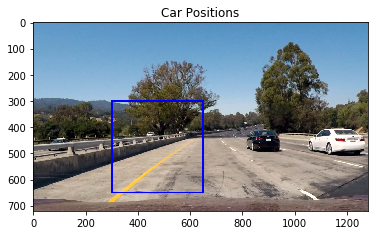

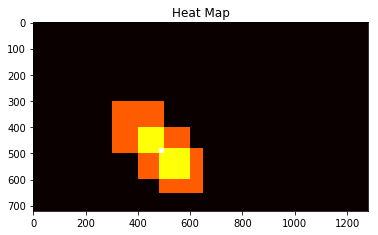

In [73]:
test_create_heat_map()

In [68]:
from skimage.feature import hog
def extract_wholeimg_hog(img):
    # Extract HOG features just once for the entire region of interest in each full image / video frame
    # The output feature_array will have a shape of (n_yblocks, n_xblocks, 2, 2, 9), 
    # where n_yblocks and n_xblocks are determined by the shape of your region of interest 
    # (i.e. how many blocks fit across and down your image in x and y). 
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2

    feature_array = hog(img, 
                        orientations=orient, 
                        pixels_per_cell=(pix_per_cell, pix_per_cell), 
                        cells_per_block=(cell_per_block, cell_per_block), 
                        visualise=False, 
                        feature_vector=False)
    return feature_array

In [69]:
def test_extract_wholeimg_hog():
    img = plt.imread('./test_images/test1.jpg')[:,:,0]
    print('raw image shape =', img.shape)
    result = extract_wholeimg_hog(img)
    print('the whole image hog feature size =', result.shape)

In [70]:
test_extract_wholeimg_hog()

raw image shape = (720, 1280)


C:\Program Files\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


the whole image hog feature size = (89, 159, 2, 2, 9)


## training, training, training ... 

#### prepare the dataset

In [59]:
# as the car and not car features hshould extracted from the same method, then use this to avoid duplicate worrk
def get_features(imgfiles):
    # return extract_features(imgfiles)
    return extract_features(imgfiles, 
                            spatial_flag = True, spatial_cspace = 'YCrCb', spatial_size = (32, 32),
                            hist_flag = True, hist_cspace = 'YCrCb', hist_bins = 32, hist_range=(0, 256),
                            hog_flag = True, hog_cspace = 'YCrCb', hog_channel = 0, hog_vis = False, hog_feature_vec = True)

In [60]:
imgfiles = glob.glob('./dataset/vehicles_smallset/*/*.jpeg')
# imgfiles = glob.glob('./dataset/vehicles/*/*.jpeg')
car_features = get_features(imgfiles)
imgfiles = glob.glob('./dataset/non-vehicles_smallset/*/*.jpeg')
# imgfiles = glob.glob('./dataset/non-vehicles/*/*.jpeg')
notcar_features = get_features(imgfiles)

In [61]:
n_car = len(car_features)
n_notcar = len(notcar_features)
print('we have ', n_car, ' car images, ', n_notcar, ' not car images')
print('feature size is ', notcar_features[0].shape)
assert notcar_features[0].shape == car_features[0].shape 

we have  1196  car images,  1125  not car images
feature size is  (4932,)


#### normalize and split dataset

In [53]:
total_features = np.vstack((notcar_features, car_features)).astype(np.float64)
total_labels = np.hstack((np.zeros(len(notcar_features)), np.ones(len(car_features))))
print('total features shape =', total_features.shape)
print('total labels shape =', total_labels.shape)

scaler = StandardScaler().fit(total_features)
total_features = scaler.transform(total_features)
print('total features normalized shape =', total_features.shape)

from sklearn.utils import shuffle
total_features, total_labels = shuffle(total_features, total_labels)
print('total features after shuffle, shape =', total_features.shape)

X_train, X_test, y_train, y_test = split_dataset(total_features, total_labels, test_size = 0.2)
print('train datasize: ', X_train.shape)
print('test datasize: ', X_test.shape)
assert X_train.shape[0] == len(y_train)
assert X_test.shape[0] == len(y_test)

total features shape = (2321, 8460)
total labels shape = (2321,)
total features normalized shape = (2321, 8460)
total features after shuffle, shape = (2321, 8460)
train datasize:  (1856, 8460)
test datasize:  (465, 8460)


#### select a classifier, and use grid search to find the best parameters

In [63]:
import pickle
retrain = False
if retrain:
    # parameters = {'kernel':('linear', 'rbf'), 'C':list(range(1, 10))}
    parameters = {'kernel':('linear', 'rbf'), 'C': [1, 10]}
    clf, clf_params_optimized = tunning_classifier(X_train, y_train, parameters)
    print('final parameters are', clf_params_optimized)

    with open('dump.pkl', 'wb') as f:
        pickle.dump(
            {
                'clf': clf,
                'param': clf_params_optimized
            }, f, pickle.HIGHEST_PROTOCOL)


In [66]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(X_train, y_train)
train_accuracy = clf.score(X_train, y_train)
print('train data shape = ', X_train.shape)
print('train accuracy is', train_accuracy)

test_accuracy = clf.score(np.array(X_test), np.array(y_test))
print('\ntest data shape = ', X_test.shape)
print('test accuracy is', accuracy)


import pickle
with open('dump.pkl', 'wb') as f:
    pickle.dump(
        {
            'clf': clf
        }, f, pickle.HIGHEST_PROTOCOL)
        

train data shape =  (1856, 4932)
train accuracy is 1.0

test data shape =  (465, 4932)
test accuracy is 0.991397849462


In [67]:
import pickle
with open('dump.pkl', 'rb') as f:
    pickle_data = pickle.load(f)
    clf = pickle_data['clf']


## pipe line for img processing

In [75]:
def img_processing(img):
    # make sure to keep consistent with the parameters used in get_features()
    ystart, ystop = 0, img.shape[0]
    X_scaler = scaler
    orient = 9
    pix_per_cell, cell_per_block = 8, 2
    orient = 9
    spatial_size = (32, 32)
    hist_bins = 32
    scale = 1.0
    hog_channel = 0
    cspace = 'YCrCb'

    bbox_lists = []
    for scale in [1.0, 1.5, 2.0, 2.5, 3.]:
        result, bbox_list = find_cars(img, 
                                      ystart = ystart, ystop = ystop, 
                                      scale = scale, svc = clf, X_scaler = X_scaler, 
                                      cspace = cspace, hog_channel = hog_channel,
                                      orient = orient, pix_per_cell = pix_per_cell, cell_per_block = cell_per_block, 
                                      spatial_size = spatial_size, hist_bins = hist_bins)
        bbox_lists.extend(bbox_list)
        if imgplot:
            fig = plt.figure()
            plt.imshow(result)
            plt.title(str(len(bbox_list)) + ' bbox for scale =' + str(scale))
    threshold = 2
    if doprint:
        print('total ', len(bbox_lists), ' bbox')
    heatmap, drawimg = create_heat_map(img, bbox_lists, threshold)
    return drawimg

In [76]:
def test_img_processing():
    img = plt.imread('./test_images/test1.jpg')
    drawimg = img_processing(img)
    plt.figure()
    plt.imshow(drawimg)
    plt.title('the final vehicle detection')


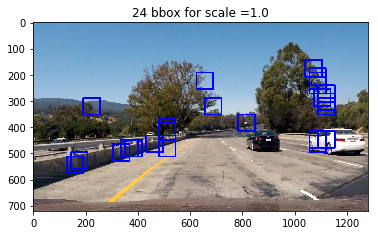

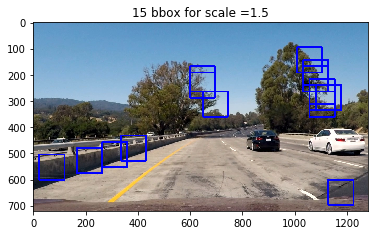

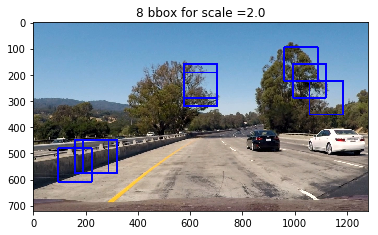

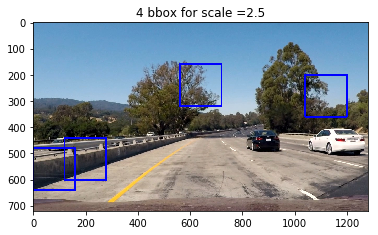

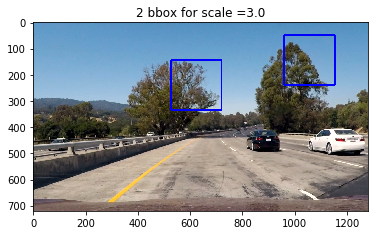

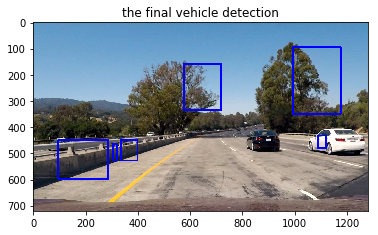

In [77]:
doprint = False
imgplot = True
test_img_processing()

handling the test images

In [126]:
imgplot = False
imgfiles = glob.glob('./test_images/*.jpg')
for imgfile in imgfiles:
    print('handling img file ', imgfile)
    img = plt.imread(imgfile)
    filename = os.path.split(imgfile)[1]
    result = img_processing(img)
    mpimg.imsave(os.path.join('output_images', filename ), result)

handling img file  ./test_images\test1.jpg
handling img file  ./test_images\test2.jpg
handling img file  ./test_images\test3.jpg
handling img file  ./test_images\test4.jpg
handling img file  ./test_images\test5.jpg
handling img file  ./test_images\test6.jpg


## pipe line for videos

In [127]:
from moviepy.editor import VideoFileClip
test_input = './test_video.mp4'
test_output = './test_solution.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds

clip1 = VideoFileClip(test_input)
# clip1 = VideoFileClip(harder_challenge_input).subclip(24, 27)

test_clip = clip1.fl_image(img_processing)
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video ./test_solution.mp4
[MoviePy] Writing video ./test_solution.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [04:27<00:06,  6.91s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_solution.mp4 

Wall time: 4min 28s


In [ ]:
from moviepy.editor import VideoFileClip
project_input = './project_video.mp4'
project_output = './project_solution.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds

clip2 = VideoFileClip(project_input)
# clip1 = VideoFileClip(harder_challenge_input).subclip(24, 27)

project_clip = clip2.fl_image(img_processing)
%time project_clip.write_videofile(project_output, audio=False)